In [1]:
from data_processing.Dataset import PixelDataset

In [2]:
from torch.utils.data import DataLoader

In [3]:
dataset = PixelDataset("../dataset/sprites.npy", "../dataset/sprites_labels.npy")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

In [4]:
len(dataset)

89400

In [5]:
for image, label in dataloader:
    print(image[0].shape)
    print(label)
    break

torch.Size([16, 16, 3])
tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])


In [6]:
from models.Autoencoder import Encoder, Decoder
import torch.nn as nn
import torch

In [23]:
encoder = Encoder()
decoder = Decoder()
autoencoder = nn.Sequential(encoder, decoder)


In [24]:
subset = torch.utils.data.Subset(dataset, range(32))
# print(len(dataset))
dataloader = DataLoader(subset, batch_size=4, shuffle=True, num_workers=0)


In [25]:
from torch.optim import Adam
from torch.nn import MSELoss
optimizer = Adam(autoencoder.parameters(), lr=0.01)

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer, epochs=5):
    size = len(dataloader.dataset)
    losses = []
    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            for batch, (X, label) in enumerate(dataloader):
                # Compute prediction error
                pred = model(X)
                loss = loss_fn(pred, X)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                if batch % 4 == 0:
                    loss, current = loss.item(), batch * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    except KeyboardInterrupt:
        pass

    return losses

In [27]:
losses = train_loop(dataloader, autoencoder, MSELoss(), optimizer, epochs=30000)

Epoch 1
-------------------------------
loss: 35116.167969  [    0/   32]
loss: 25435.078125  [   16/   32]
Epoch 2
-------------------------------
loss: 14427.838867  [    0/   32]
loss: 15857.563477  [   16/   32]
Epoch 3
-------------------------------
loss: 13133.549805  [    0/   32]
loss: 12271.210938  [   16/   32]
Epoch 4
-------------------------------
loss: 10939.475586  [    0/   32]
loss: 10453.936523  [   16/   32]
Epoch 5
-------------------------------
loss: 10251.237305  [    0/   32]
loss: 10801.981445  [   16/   32]
Epoch 6
-------------------------------
loss: 10240.206055  [    0/   32]
loss: 9996.196289  [   16/   32]
Epoch 7
-------------------------------
loss: 9827.492188  [    0/   32]
loss: 9161.867188  [   16/   32]
Epoch 8
-------------------------------
loss: 8911.433594  [    0/   32]
loss: 8595.961914  [   16/   32]
Epoch 9
-------------------------------
loss: 9839.172852  [    0/   32]
loss: 9309.032227  [   16/   32]
Epoch 10
--------------------------

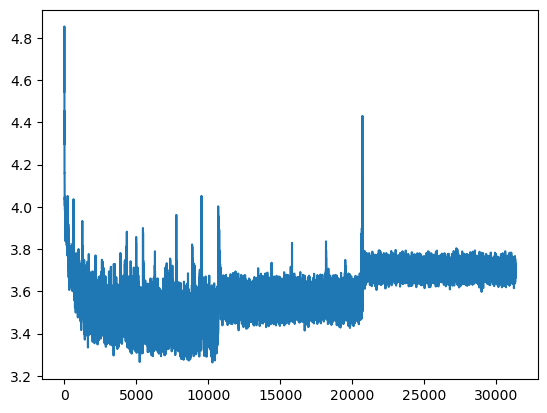

In [35]:
import matplotlib.pyplot as plt
plt.plot(torch.log10(torch.tensor(losses)))

torch.Size([3, 16, 16])
torch.Size([4, 3, 16, 16])
torch.Size([3, 20, 74])


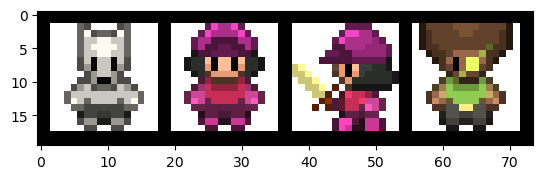

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


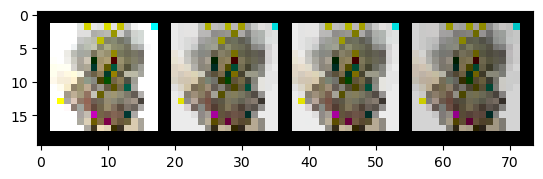

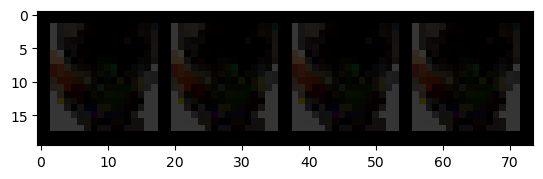

In [32]:
dataset[0][0]
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
images_not, _ = next(iter(dataloader))
images = torch.stack([image.permute(2,0,1).int() for image in images_not])
print(images[3].int().shape)
print(images.shape)
grid = make_grid(images, nrow=4, padding = 2)
print(grid.shape)
plt.imshow(grid.permute(1,2,0))

plt.show()

autoencoder.eval()
with torch.no_grad():
    output = autoencoder(images_not)
    output = torch.stack([image.permute(2,0,1).int() for image in output])
    grid = make_grid(output, nrow=4, padding = 2)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

with torch.no_grad():
    images_not = torch.randn(4, 16, 16, 3)
    output = autoencoder(images_not)
    output = torch.stack([image.permute(2,0,1).int() for image in output])
    grid = make_grid(output, nrow=4, padding = 2)
    plt.imshow(grid.permute(1,2,0))
    plt.show()


